# Description of Data

Attribute Information:
1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# Load Packages

In [ ]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install keras-tuner

In [ ]:
pip install keras-tcn

In [ ]:
from tcn import TCN, tcn_full_summary, compiled_tcn, tcn
from tensorflow.keras.models import Sequential

In [ ]:
import keras_tuner as kt # For hyperparameter optmization
from keras_tuner import RandomSearch
from keras_tuner import BayesianOptimization
from keras_tuner import Hyperband

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/household_power_consumption.txt',
                 sep = ';', parse_dates = {'dt' : ['Date', 'Time']}, infer_datetime_format = True,
                 low_memory = False, na_values = ['nan','?'], index_col = 'dt')

In [ ]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
tf.random.set_seed(1234)

# General Function Definitions

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def avg(nums):
    nums = list(nums)
    return round(sum(nums) / len(nums), 4)

def scale_data(dat, range =(0,1)):
  ## * Note: I scale all features in range of [0,1].

  ## If you would like to train based on the resampled data (over hour), then used below
  values = dat.values
  # normalize features
  scaler = MinMaxScaler(feature_range=range)
  scaled = scaler.fit_transform(values)

  #print(type(scaled))
  print("Shape of scaled dataset-",scaled.shape)
  #print(pd.DataFrame(scaled))

  return scaler, scaled
 

#Deep-Leaning: LSTM Data Preparation and feature engineering

* Missing value treatment

* As readings are for each minute, we can replcae the missing values with reading obtained 24 hours ago
* This is a very simple approach.Better way would be to calculate the average 
* usage of a particular time for a window duration and then use that value to replace the missing values

* Fill the missing values with reading obtained 24 hours ago
* 1 hour has 60 observations


In [ ]:
# Check for na values
df.isna().sum()
# Readings for 25979 observations missing

# Check the proportion of missing values

df.isna().sum()/df.shape[0]

Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

In [ ]:
def fill_missing(dat):
    window = 60 * 24
    for row in range(dat.shape[0]):
        for col in range(dat.shape[1]):
            if np.isnan(dat[row,col]):
                dat[row, col] = dat[row - window, col]

In [ ]:
fill_missing(df.values)
df.isna().sum()

#df.head()
#df.info()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

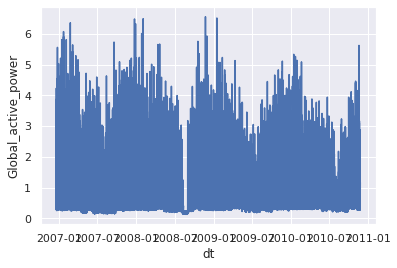

In [ ]:
# As our focus is on getting a read on daily consumption it is a good idea
# to downsample the data to daily readings

df_resampled_hourly_avg = df.resample('H').mean()
df_resampled_hourly_avg.head()
df_resampled_hourly_avg.shape
# 34589,7
sns.lineplot(data=df_resampled_hourly_avg, y='Global_active_power',
             x=df_resampled_hourly_avg.index)

df_resample = df_resampled_hourly_avg.resample('D').mean()

* Data resampled at day level just for comparison


In [ ]:
## resampling of data over hour
#df_resample = df.resample('D').mean() 
print(df_resample) 
df_resample.shape

            Global_active_power  ...  Sub_metering_3
dt                               ...                
2006-12-16             3.120298  ...       12.692063
2006-12-17             2.354486  ...        9.264583
2006-12-18             1.530435  ...        9.734722
2006-12-19             1.157079  ...        4.303472
2006-12-20             1.545658  ...        9.765972
...                         ...  ...             ...
2010-11-22             1.417733  ...        7.038889
2010-11-23             1.095511  ...        5.285417
2010-11-24             1.247394  ...        8.488889
2010-11-25             0.993864  ...        3.522222
2010-11-26             1.167712  ...        7.567424

[1442 rows x 7 columns]


(1442, 7)

In [ ]:
import calendar
calendar.day_name[df_resample.index.weekday[0]]

'Saturday'

* Starting day in data is a **Saturday**
* We will remove first 2 observations so that data starts from Monday, so that it is easy to visualize a weekly seasonality if it exists

In [ ]:
df_resample_sliced = df_resample[2:]
df_resample_sliced.shape
calendar.day_name[df_resample_sliced.index.weekday[0]]

'Monday'

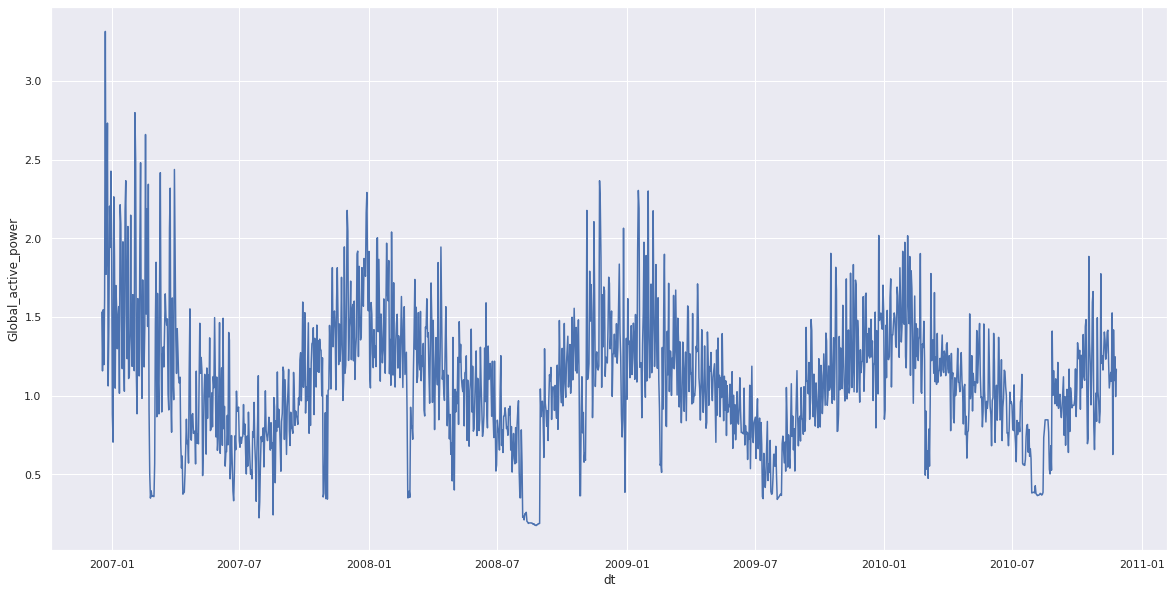

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(figsize = (20,10))
sns.lineplot(data = df_resample_sliced, y = 'Global_active_power', x = df_resample_sliced.index)

**Active power usage by Month**

In [ ]:
df_resample_sliced.groupby(df_resample_sliced.index.strftime('%b'), sort = False)['Global_active_power'].mean()

dt
Dec    1.477656
Jan    1.460179
Feb    1.300928
Mar    1.230836
Apr    1.039632
May    1.029559
Jun    0.906512
Jul    0.700587
Aug    0.583312
Sep    0.974386
Oct    1.137197
Nov    1.291483
Name: Global_active_power, dtype: float64

* We can clearly see that there is a monthly seasonality present in power consumed by appliances(Global active power
* Usage drops around middle of the year and peaking towards the end of year

**Active power usage by Weekday**

In [ ]:
df_resample_sliced.groupby(df_resample_sliced.index.strftime('%a'), sort = False)['Global_active_power'].mean()

dt
Mon    0.997309
Tue    1.069351
Wed    1.082994
Thu    0.980880
Fri    1.042470
Sat    1.238724
Sun    1.206729
Name: Global_active_power, dtype: float64

* Usage peaks around weekend and weekday usage more or less remains similar which is what we are expecting 

In [ ]:

df_resample_day = df_resample_sliced


df_resample_day.head()

# Min and Max dates
df_resample_day.index.min()
# 2006-12-18
df_resample_day.index.max()
# 2010-11-26

df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]

df_resample_day_y.head()
print(type(df_resample_day_y))

<class 'pandas.core.frame.DataFrame'>


**Transform the data into a time series problem**

In [ ]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)   var1(t)
1   0.431901   0.234750   0.620518  ...   0.216451   0.566912  0.313037
2   0.313037   0.202322   0.667476  ...   0.627798   0.218615  0.436748
3   0.436748   0.232377   0.686364  ...   0.218680   0.568916  0.325660
4   0.325660   0.182871   0.608740  ...   0.222314   0.408283  0.462304
5   0.462304   0.309810   0.617634  ...   0.028904   0.438343  1.000000

[5 rows x 8 columns]


In [ ]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
      var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7     -0.136197  -0.373925  -0.126504  ...   1.000000   0.016878  0.102266
8     -0.373925  -0.126504  -0.348679  ...   0.016878   0.102266  0.628892
9     -0.126504  -0.348679  -0.075393  ...   0.102266   0.628892 -0.434695
10    -0.348679  -0.075393   1.000000  ...   0.628892  -0.434695 -0.194205
11    -0.075393   1.000000   0.016878  ...  -0.434695  -0.194205  0.292964
...         ...        ...        ...  ...        ...        ...       ...
1435  -0.338026  -0.443102  -0.411139  ...  -0.139213  -0.712315 -0.207958
1436  -0.443102  -0.411139  -0.380134  ...  -0.712315  -0.207958 -0.413127
1437  -0.411139  -0.380134  -0.416283  ...  -0.207958  -0.413127 -0.316418
1438  -0.38

# Model - 1(LSTM)

**Splitting the data to train and validation sets**

We will be using almost last 6 months of our data as validation data to check how our deep learning network is performing

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 1, 7) (1200,) (233, 1, 7) (233,)


In [ ]:
mape_lst = list()

Epoch 1/20
18/18 - 3s - loss: 0.1506 - val_loss: 0.0728
Epoch 2/20
18/18 - 0s - loss: 0.0548 - val_loss: 0.0202
Epoch 3/20
18/18 - 0s - loss: 0.0421 - val_loss: 0.0197
Epoch 4/20
18/18 - 0s - loss: 0.0410 - val_loss: 0.0197
Epoch 5/20
18/18 - 0s - loss: 0.0411 - val_loss: 0.0197
Epoch 6/20
18/18 - 0s - loss: 0.0405 - val_loss: 0.0195
Epoch 7/20
18/18 - 0s - loss: 0.0404 - val_loss: 0.0194
Epoch 8/20
18/18 - 0s - loss: 0.0403 - val_loss: 0.0194
Epoch 9/20
18/18 - 0s - loss: 0.0394 - val_loss: 0.0193
Epoch 10/20
18/18 - 0s - loss: 0.0398 - val_loss: 0.0193
Epoch 11/20
18/18 - 0s - loss: 0.0391 - val_loss: 0.0193
Epoch 12/20
18/18 - 0s - loss: 0.0390 - val_loss: 0.0194
Epoch 13/20
18/18 - 0s - loss: 0.0389 - val_loss: 0.0194
Epoch 14/20
18/18 - 0s - loss: 0.0383 - val_loss: 0.0194
Epoch 15/20
18/18 - 0s - loss: 0.0389 - val_loss: 0.0194
Epoch 16/20
18/18 - 0s - loss: 0.0375 - val_loss: 0.0194
Epoch 17/20
18/18 - 0s - loss: 0.0372 - val_loss: 0.0194
Epoch 18/20
18/18 - 0s - loss: 0.0375 - 

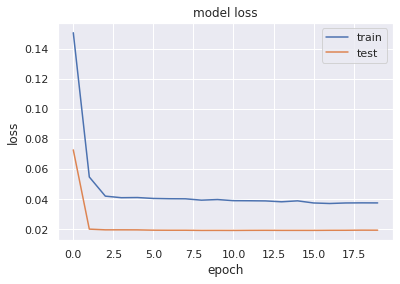

Test RMSE: 0.219
MAPE: 18.637


In [ ]:

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_lstm))
print('Test RMSE: %.3f' % rmse)
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)

In [ ]:
len(inv_yhat_lstm)

233

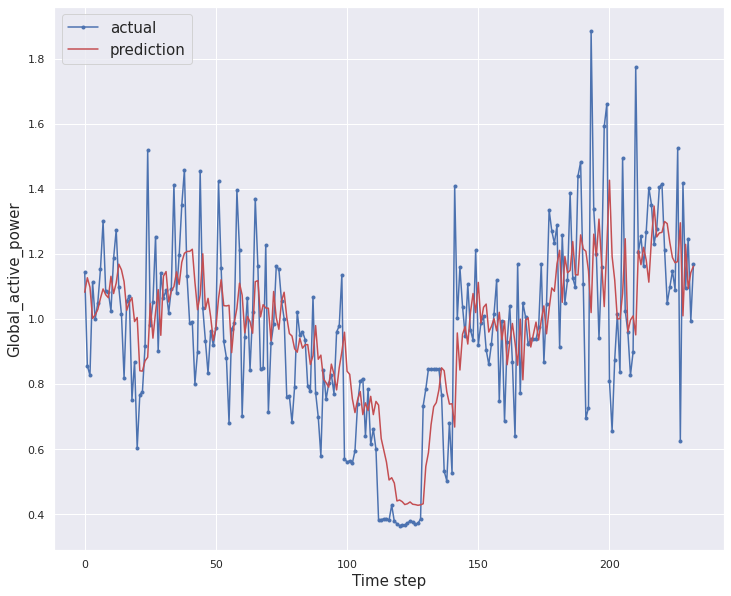

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 

fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(len(test_X))]
plt.plot(aa, inv_y[:len(test_X)], marker='.', label="actual")
plt.plot(aa, inv_yhat_lstm[:len(test_X)], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Identify the suitable window for lags

In [ ]:
## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]


In [ ]:
lags = 31
model_details = {}
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units = 128, input_shape = (train_X.shape[1], train_X.shape[2])))
    model.add(Dense(units = 1))
    model.compile(loss = 'mean_absolute_error', optimizer = 'adam')
    return model

def run_model(model, train_data, validation_data):
    model_det_dict = {}
    n_features = train_data[0].shape[2]
    history = model.fit(train_data[0], train_data[1],  epochs=20, 
                        validation_data=(validation_data[0],validation_data[1]),
                        verbose=2, shuffle=False)
    # We reshaped the input into the 3D format as expected by LSTMs, 
    # make a prediction
    yhat = model.predict(test_X)
    x_test = validation_data[0].reshape((validation_data[0].shape[0], n_features))
    #print(x_test)
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, x_test), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    y_test = validation_data[1].reshape((len(validation_data[1]), 1))
    inv_y = np.concatenate((y_test, x_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat)
    print('MAPE: %.3f' % loss)
    model_det_dict = {'n_features': n_features,
                      'Val_RMSE':rmse,
                      'Val_MAPE':loss.numpy(),
                      'actual': inv_y,
                      'predicted': inv_yhat}
    print(model_det_dict)
    return model_det_dict
    

for lag in range(1, lags + 1):
    reframed = series_to_supervised(scaled, lag, 1)
    print(reframed.shape)
    # split into train and test sets
    values = reframed.values
    n_train_time = 1200
    train = values[:n_train_time, :]
    test = values[n_train_time:, :]
    train.shape, test.shape
    ##test = values[n_train_time:n_test_time, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    n_features = train_X.shape[2]
    model = build_lstm_model()
    model_details['Model_'+str(lag)] = run_model(model, train_data=(train_X, train_y),
                                validation_data=(test_X, test_y))
    
    #print(model_details)
    
for model_id, model_data in model_details.items():
    print("Model_ID:", model_id)
    print(f"ValidationData-RMSE: {model_data['Val_RMSE']:.3f}")
    print(f"ValidationData-MAPE: {model_data['Val_MAPE']:.3f}")
    print(10*"#")
        
    


(1439, 2)
(1200, 1, 1) (1200,) (239, 1, 1) (239,)
Epoch 1/20
38/38 - 2s - loss: 0.3468 - val_loss: 0.2539
Epoch 2/20
38/38 - 0s - loss: 0.2000 - val_loss: 0.1196
Epoch 3/20
38/38 - 0s - loss: 0.1790 - val_loss: 0.1176
Epoch 4/20
38/38 - 0s - loss: 0.1755 - val_loss: 0.1152
Epoch 5/20
38/38 - 0s - loss: 0.1727 - val_loss: 0.1135
Epoch 6/20
38/38 - 0s - loss: 0.1707 - val_loss: 0.1119
Epoch 7/20
38/38 - 0s - loss: 0.1691 - val_loss: 0.1114
Epoch 8/20
38/38 - 0s - loss: 0.1682 - val_loss: 0.1105
Epoch 9/20
38/38 - 0s - loss: 0.1674 - val_loss: 0.1101
Epoch 10/20
38/38 - 0s - loss: 0.1669 - val_loss: 0.1099
Epoch 11/20
38/38 - 0s - loss: 0.1665 - val_loss: 0.1097
Epoch 12/20
38/38 - 0s - loss: 0.1663 - val_loss: 0.1095
Epoch 13/20
38/38 - 0s - loss: 0.1660 - val_loss: 0.1095
Epoch 14/20
38/38 - 0s - loss: 0.1659 - val_loss: 0.1093
Epoch 15/20
38/38 - 0s - loss: 0.1657 - val_loss: 0.1092
Epoch 16/20
38/38 - 0s - loss: 0.1656 - val_loss: 0.1091
Epoch 17/20
38/38 - 0s - loss: 0.1656 - val_los

* We ran a LSTM architecture with different sets of lags from 1 to 31
* This is done to identify which lag will give a better result
* From the output we can see that a window size of 7 days works best. 
* Any information more than 2 weeks cause a drop in model performance

# Model - 2(CNN)

**CNN for Time Series Forecasting**

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

**Data preprocess**
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
      var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7     -0.136197  -0.373925  -0.126504  ...   1.000000   0.016878  0.102266
8     -0.373925  -0.126504  -0.348679  ...   0.016878   0.102266  0.628892
9     -0.126504  -0.348679  -0.075393  ...   0.102266   0.628892 -0.434695
10    -0.348679  -0.075393   1.000000  ...   0.628892  -0.434695 -0.194205
11    -0.075393   1.000000   0.016878  ...  -0.434695  -0.194205  0.292964
...         ...        ...        ...  ...        ...        ...       ...
1435  -0.338026  -0.443102  -0.411139  ...  -0.139213  -0.712315 -0.207958
1436  -0.443102  -0.411139  -0.380134  ...  -0.712315  -0.207958 -0.413127
1437  -0.411139  -0.380134  -0.416283  ...  -0.207958  -0.413127 -0.316418
1438  -0.38

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam())
#model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, train_y, validation_data=(X_valid_series, test_y), epochs=20, verbose=2)
model_cnn.summary()

Epoch 1/20
38/38 - 1s - loss: 0.0781 - val_loss: 0.0241
Epoch 2/20
38/38 - 0s - loss: 0.0418 - val_loss: 0.0206
Epoch 3/20
38/38 - 0s - loss: 0.0401 - val_loss: 0.0205
Epoch 4/20
38/38 - 0s - loss: 0.0391 - val_loss: 0.0216
Epoch 5/20
38/38 - 0s - loss: 0.0387 - val_loss: 0.0202
Epoch 6/20
38/38 - 0s - loss: 0.0376 - val_loss: 0.0205
Epoch 7/20
38/38 - 0s - loss: 0.0374 - val_loss: 0.0208
Epoch 8/20
38/38 - 0s - loss: 0.0373 - val_loss: 0.0203
Epoch 9/20
38/38 - 0s - loss: 0.0365 - val_loss: 0.0204
Epoch 10/20
38/38 - 0s - loss: 0.0366 - val_loss: 0.0204
Epoch 11/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0203
Epoch 12/20
38/38 - 0s - loss: 0.0364 - val_loss: 0.0217
Epoch 13/20
38/38 - 0s - loss: 0.0374 - val_loss: 0.0206
Epoch 14/20
38/38 - 0s - loss: 0.0359 - val_loss: 0.0203
Epoch 15/20
38/38 - 0s - loss: 0.0354 - val_loss: 0.0203
Epoch 16/20
38/38 - 0s - loss: 0.0351 - val_loss: 0.0209
Epoch 17/20
38/38 - 0s - loss: 0.0345 - val_loss: 0.0203
Epoch 18/20
38/38 - 0s - loss: 0.0353 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn.predict(X_train_series)
yhat = model_cnn.predict(X_valid_series)
# invert scaling for forecast
inv_yhat_cnn = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn = scaler.inverse_transform(inv_yhat_cnn)
inv_yhat_cnn = inv_yhat_cnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)



Train rmse: 0.18277140307840292
Validation rmse: 0.2211415362727364
MAPE: 18.864


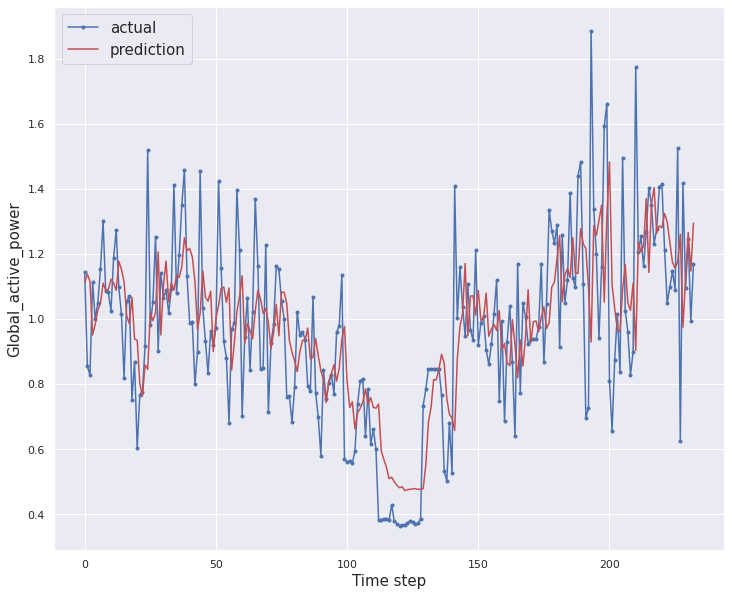

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, Dense, Flatten, MaxPooling1D

In [ ]:
# model_cnn = Sequential()
# model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
# model_cnn.add(MaxPooling1D(pool_size=2))
# model_cnn.add(Flatten())
# model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dense(1))
# model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam())
# #model_cnn.summary()
inputs = Input(shape=(7,1))
x = Conv1D(filters=128, kernel_size=2, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(units=50, activation='relu')(x)
output = Dense(units=1)(x)

model = Model(inputs, output, name='Vanilla_CNN')
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

Model: "Vanilla_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 128)            384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                19250     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 19,685
Trainable params: 19,685
Non-trainable params: 0
___________________________________________________

# Model -3(CNN + LSTM)

**CNN-LSTM for Time Series Forecasting**
* Input shape **[samples, subsequences, timesteps, features]**.

 Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

 **Data preprocess**
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1200, 1, 7, 1)
Validation set shape (233, 1, 7, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(100, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_85 (ModuleWra (None, 128)               81920     
_________________________________________________________________
module_wrapper_86 (ModuleWra (None, 1)                 129       
Total params: 82,049
Trainable params: 82,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=20, verbose=2)

Epoch 1/20
38/38 - 2s - loss: 0.0771 - val_loss: 0.0268
Epoch 2/20
38/38 - 0s - loss: 0.0427 - val_loss: 0.0208
Epoch 3/20
38/38 - 0s - loss: 0.0415 - val_loss: 0.0207
Epoch 4/20
38/38 - 0s - loss: 0.0396 - val_loss: 0.0215
Epoch 5/20
38/38 - 0s - loss: 0.0388 - val_loss: 0.0221
Epoch 6/20
38/38 - 0s - loss: 0.0387 - val_loss: 0.0208
Epoch 7/20
38/38 - 0s - loss: 0.0384 - val_loss: 0.0217
Epoch 8/20
38/38 - 0s - loss: 0.0384 - val_loss: 0.0209
Epoch 9/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0205
Epoch 10/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0225
Epoch 11/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0217
Epoch 12/20
38/38 - 0s - loss: 0.0362 - val_loss: 0.0203
Epoch 13/20
38/38 - 0s - loss: 0.0364 - val_loss: 0.0235
Epoch 14/20
38/38 - 0s - loss: 0.0363 - val_loss: 0.0198
Epoch 15/20
38/38 - 0s - loss: 0.0354 - val_loss: 0.0213
Epoch 16/20
38/38 - 0s - loss: 0.0352 - val_loss: 0.0216
Epoch 17/20
38/38 - 0s - loss: 0.0353 - val_loss: 0.0221
Epoch 18/20
38/38 - 0s - loss: 0.0356 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn_lstm.predict(X_train_series_sub)

yhat = model_cnn_lstm.predict(X_valid_series_sub)
# invert scaling for forecast
inv_yhat_cnn_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn_lstm = scaler.inverse_transform(inv_yhat_cnn_lstm)
inv_yhat_cnn_lstm = inv_yhat_cnn_lstm[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn_lstm)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




Train rmse: 0.18204525077996642
Validation rmse: 0.22264090642167061
MAPE: 19.065


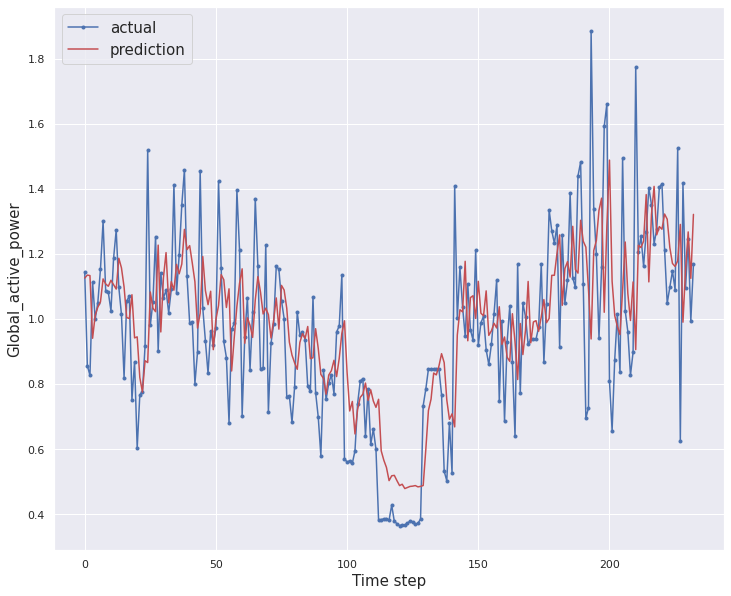

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn_lstm[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Model -4(TCN)

**Temporal CNN**

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
# if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.

tcn_layer = TCN(input_shape=(7, 1),
                nb_filters = 128,
                dilations = (1,2,4,8),
                activation = 'relu',
                use_skip_connections = True)

# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

model_tcn = Sequential([
    tcn_layer,
    Dense(1)
])

model_tcn.compile(optimizer='adam', loss='mse')
model_tcn.summary()
#tcn_full_summary(m, expand_residual_blocks=False)

model_tcn.fit(X_train_series, train_y, validation_data=(X_valid_series, test_y), epochs=20)

Receptive field size = 61
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               345728    
_________________________________________________________________
module_wrapper_97 (ModuleWra (None, 1)                 129       
Total params: 345,857
Trainable params: 345,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
38/38 [==============================] - 5s 86ms/step - loss: 0.6942 - val_loss: 0.0205
Epoch 2/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0451 - val_loss: 0.0260
Epoch 3/20
38/38 [==============================] - 1s 34ms/step - loss: 0.0371 - val_loss: 0.0202
Epoch 4/20
38/38 [==============================] - 1s 36ms/step - loss: 0.0380 - val_loss: 0.0211
Epoch 5/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0357 - val_l

In [ ]:

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

tcn_train_pred = model_tcn.predict(X_train_series)

yhat = model_tcn.predict(X_valid_series)
# invert scaling for forecast
inv_yhat_tcn = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_tcn = scaler.inverse_transform(inv_yhat_tcn)
inv_yhat_tcn = inv_yhat_tcn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, tcn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_tcn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_tcn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)


Train rmse: 0.16113453996914098
Validation rmse: 0.2326654289388346
MAPE: 21.396


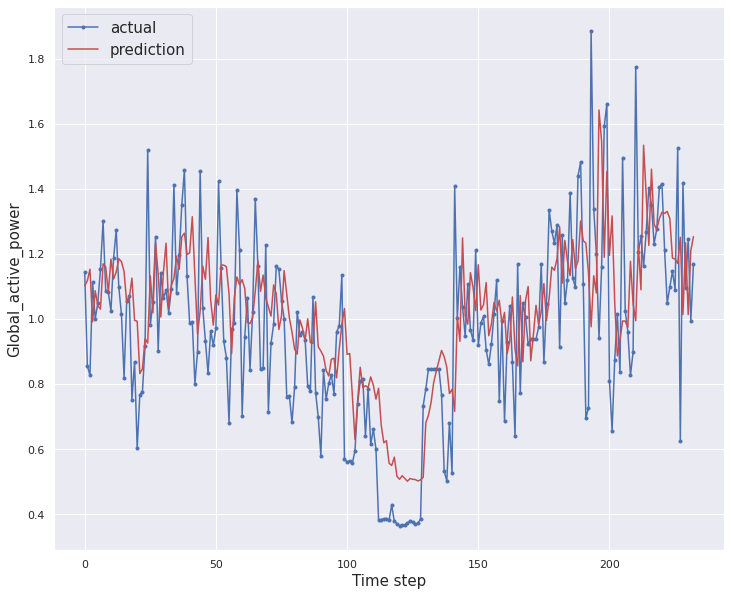

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_tcn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
mape_lst[0].eval

<bound method _EagerTensorBase.eval of <tf.Tensor: shape=(), dtype=float64, numpy=27.12617896616368>>

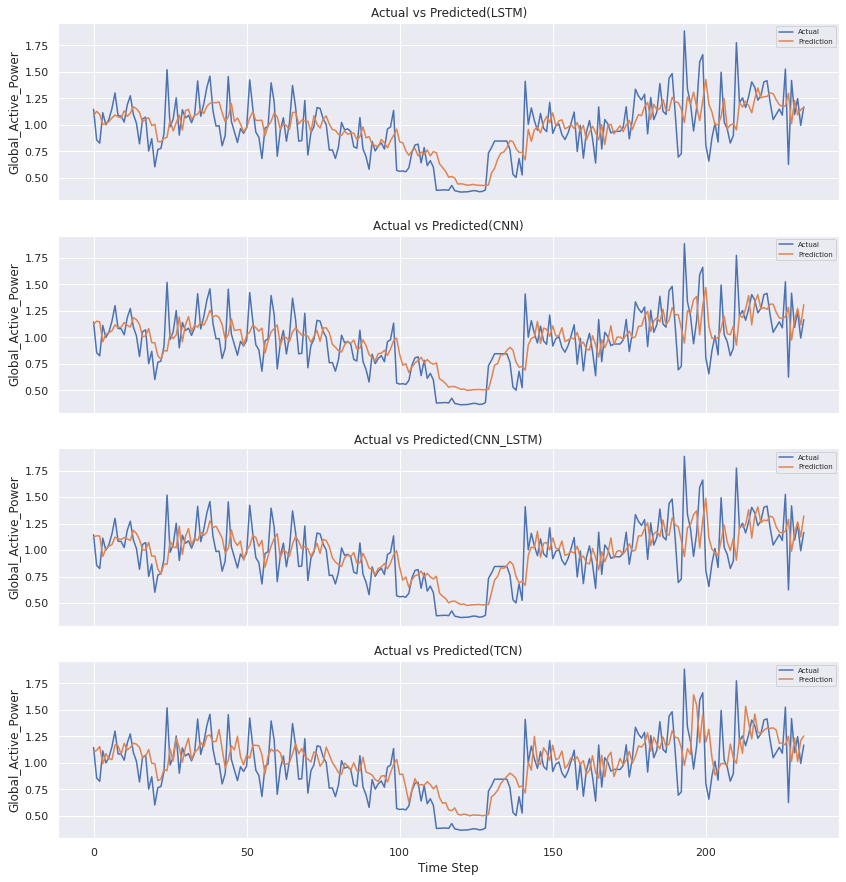

In [ ]:
data = {"Actual" : inv_y, "LSTM": inv_yhat_lstm, "CNN":inv_yhat_cnn,
              "CNN_LSTM": inv_yhat_cnn_lstm, "TCN":inv_yhat_tcn}
a_vs_p = pd.DataFrame(data)
a_vs_p

fig, axs=  plt.subplots(4, sharex= True, figsize = (14,15))
aa = [x for x in range(a_vs_p.shape[0])]
for i in range(4):
  axs[i].plot(aa, a_vs_p.iloc[:,0], label = 'Actual')
  axs[i].plot(aa, a_vs_p.iloc[:, i +1], label = 'Prediction')
  axs[i].set_title("Actual vs Predicted(" + list(data.keys())[i+1]+")")
  axs[i].legend(fontsize = 7)

for ax in axs.flat:
  ax.set(xlabel='Time Step', ylabel='Global_Active_Power')

for ax in axs.flat:
  ax.label_outer()

'Predicted_LSTM'

# Model-5(MACNN)

In [ ]:
#df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 28, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
      var1(t-28)  var1(t-27)  var1(t-26)  ...  var1(t-2)  var1(t-1)   var1(t)
28     -0.136197   -0.373925   -0.126504  ...   0.298456   0.220027 -0.160582
29     -0.373925   -0.126504   -0.348679  ...   0.220027  -0.160582 -0.364989
30     -0.126504   -0.348679   -0.075393  ...  -0.160582  -0.364989  0.148503
31     -0.348679   -0.075393    1.000000  ...  -0.364989   0.148503 -0.305269
32     -0.075393    1.000000    0.016878  ...   0.148503  -0.305269 -0.456061
...          ...         ...         ...  ...        ...        ...       ...
1435   -0.596296   -0.692420   -0.553411  ...  -0.139213  -0.712315 -0.207958
1436   -0.692420   -0.553411   -0.463628  ...  -0.712315  -0.207958 -0.413127
1437   -0.553411   -0.463628   -0.578109  ...  -0.207958  -

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 28) (1200,) (212, 28) (212,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 28, 1)
Validation set shape (212, 28, 1)


In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D,  Dense, concatenate, Multiply
from keras.activations import ReLU


In [ ]:
from keras.activations import relu

## Iteration-1

In [ ]:
inputs = Input(shape=(28,1), name='series')
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
conv1 = concatenate([conv1_a, conv1_b, conv1_c])

conv1 = BatchNormalization()(conv1)
msblock = ReLU()(conv1)
out = GlobalAveragePooling1D()(msblock)

# Flatten the ouput
#out = Flatten()(out)
out = Dense(units=64)(out)
out = Dense(units=192)(out)
out = ReLU()(out)

attblock = Multiply()([out, msblock])
attblock = Flatten()(attblock)
attblock = Dense(units=1)(attblock)

model = Model(inputs, attblock, name='MACNN')
model.compile(optimizer='Adam', loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,shuffle=False)

Epoch 1/100
38/38 [==============================] - 3s 44ms/step - loss: 0.3558 - val_loss: 0.4835
Epoch 2/100
38/38 [==============================] - 1s 27ms/step - loss: 0.2470 - val_loss: 0.4764
Epoch 3/100
38/38 [==============================] - 1s 28ms/step - loss: 0.1600 - val_loss: 0.4660
Epoch 4/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1796 - val_loss: 0.4562
Epoch 5/100
38/38 [==============================] - 1s 33ms/step - loss: 0.1656 - val_loss: 0.4460
Epoch 6/100
38/38 [==============================] - 1s 29ms/step - loss: 0.1606 - val_loss: 0.4428
Epoch 7/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1708 - val_loss: 0.4329
Epoch 8/100
38/38 [==============================] - 1s 28ms/step - loss: 0.1444 - val_loss: 0.4277
Epoch 9/100
38/38 [==============================] - 1s 29ms/step - loss: 0.1384 - val_loss: 0.4224
Epoch 10/100
38/38 [==============================] - 1s 31ms/step - loss: 0.1277 - val_loss: 0.4082

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)



(1200,)
Train rmse: 0.21480185106211008
Validation rmse: 0.31621114924516547
MAPE: 30.208


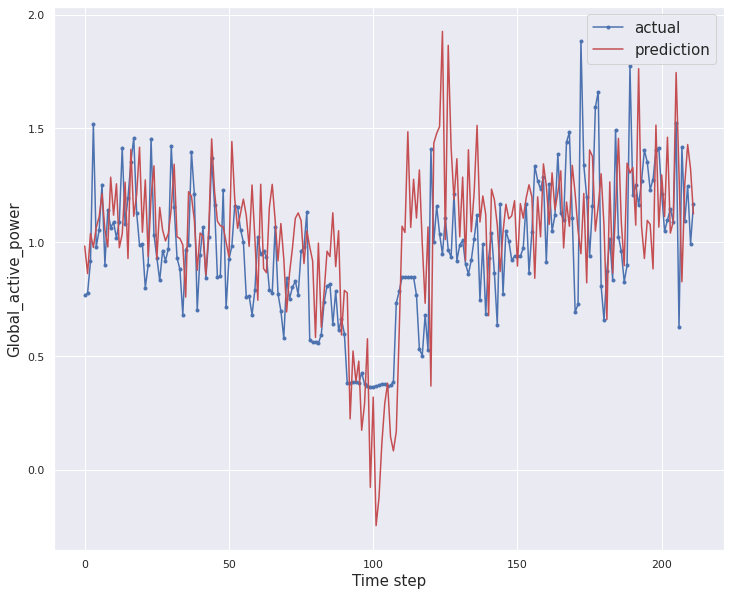

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Iteration-2

* Change learning rate to 0.0002
* Multiplied another CNN output which has a wider receptive field which smoothend the output

In [ ]:
inputs = Input(shape=(28,1), name='series')
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
conv1 = concatenate([conv1_a, conv1_b, conv1_c])
conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

#conv1 = BatchNormalization()(conv1)
msblock = relu(conv1)
out = GlobalAveragePooling1D()(conv1)

# Flatten the ouput
#out = Flatten()(out)
out = Dense(units=64)(out)
out = Dense(units=192)(out)
out = relu(out)

attblock = Multiply()([out, msblock, conv2])
attblock = Flatten()(attblock)
attblock = Dense(units=1)(attblock)

model = Model(inputs, attblock, name='MACNN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,batch_size=10, shuffle=False)

Epoch 1/100
120/120 [==============================] - 17s 14ms/step - loss: 0.4170 - val_loss: 0.2002
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 0.2452 - val_loss: 0.1632
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 0.2124 - val_loss: 0.1743
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1948 - val_loss: 0.1426
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1876 - val_loss: 0.1383
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1840 - val_loss: 0.1352
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1795 - val_loss: 0.1341
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1731 - val_loss: 0.1262
Epoch 9/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1655 - val_loss: 0.1301
Epoch 10/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1614 - val_

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




(1200,)
Train rmse: 0.13054193285030652
Validation rmse: 0.22860177627741324
MAPE: 20.408


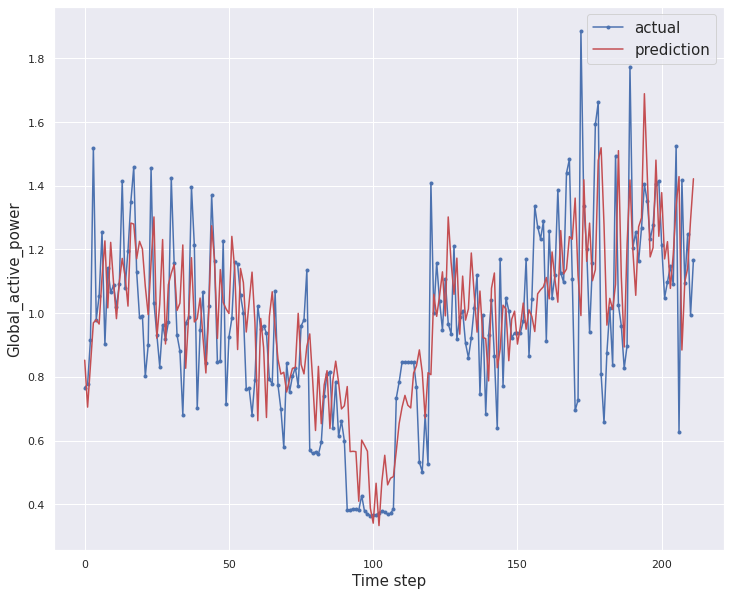

In [ ]:
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


## Iteration-3

* Add section - 2 from paper

In [ ]:
inputs = Input(shape=(28,1), name='series')


# Section - 1
#----------------------------------------------------------------------------------------
# Stack -1 
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)
#
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])

out = x * y

# Stack 2
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(out)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(out)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])
out = x * y
final_out = MaxPooling1D(3,2,padding='same')(out)


# Section - 2
# -----------------------------------------------------------------------------------
# Stack - 1
# Kernel filters = 128

#final_out = tf.reduce_mean(final_out, 1)
#final_out = Dense(units=1)(final_out)
conv1_a = Conv1D(filters=128,kernel_size=2, activation='relu',padding='same')(final_out)
conv1_b = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(final_out)
conv1_c = Conv1D(filters=128,kernel_size=14,activation='relu',padding='same')(final_out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=24, use_bias=False,activation='relu')(y)
y = Dense(units=384,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,384])



out = x * y

final_out = tf.reduce_mean(out, 1)
final_out = Dense(units=1)(final_out)
model = Model(inputs,final_out, name='MACNN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,batch_size=10, shuffle=False)

Epoch 1/100
120/120 [==============================] - 9s 56ms/step - loss: 0.4367 - val_loss: 0.3836
Epoch 2/100
120/120 [==============================] - 6s 52ms/step - loss: 0.2422 - val_loss: 0.1390
Epoch 3/100
120/120 [==============================] - 6s 50ms/step - loss: 0.2023 - val_loss: 0.1308
Epoch 4/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2031 - val_loss: 0.1301
Epoch 5/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2022 - val_loss: 0.1300
Epoch 6/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2021 - val_loss: 0.1296
Epoch 7/100
120/120 [==============================] - 6s 52ms/step - loss: 0.2017 - val_loss: 0.1291
Epoch 8/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2014 - val_loss: 0.1284
Epoch 9/100
120/120 [==============================] - 6s 50ms/step - loss: 0.2010 - val_loss: 0.1280
Epoch 10/100
120/120 [==============================] - 6s 50ms/step - loss: 0.199

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




(1200,)
Train rmse: 0.16416826312625865
Validation rmse: 0.2284492447010035
MAPE: 21.031


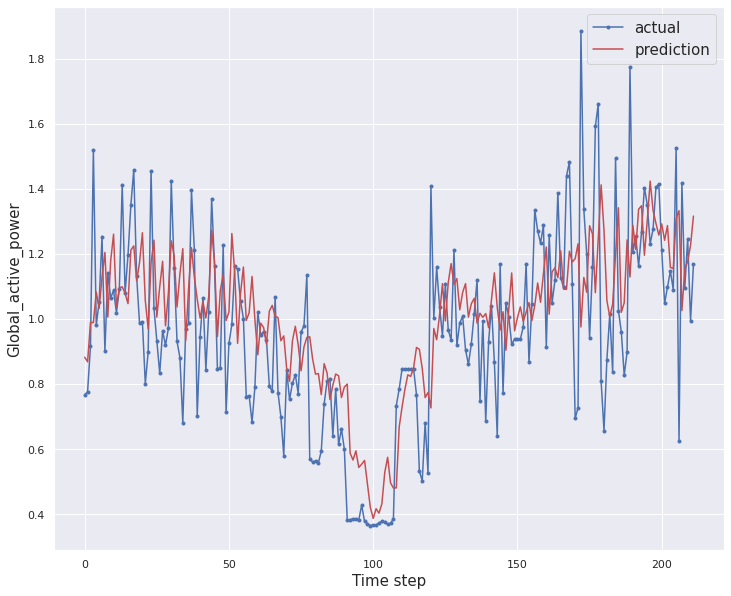

In [ ]:
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


## Iteration-4

* Adding stack 2 of section -2

In [ ]:
inputs = Input(shape=(28,1), name='series')


# Section - 1
#----------------------------------------------------------------------------------------
# Stack -1 
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)
#
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])

out = x * y

# Stack 2
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(out)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(out)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])
out = x * y
final_out = MaxPooling1D(3,2,padding='same')(out)


# Section - 2
# -----------------------------------------------------------------------------------
# Stack - 1
# Kernel filters = 128

#final_out = tf.reduce_mean(final_out, 1)
#final_out = Dense(units=1)(final_out)
conv1_a = Conv1D(filters=128,kernel_size=2, activation='relu',padding='same')(final_out)
conv1_b = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(final_out)
conv1_c = Conv1D(filters=128,kernel_size=14,activation='relu',padding='same')(final_out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=24, use_bias=False,activation='relu')(y)
y = Dense(units=384,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,384])



out = x * y

# Stack 2
kernels = 128
conv1_a = Conv1D(filters=kernels,kernel_size=2, activation='relu',padding='same')(out)
conv1_b = Conv1D(filters=kernels,kernel_size=7,activation='relu',padding='same')(out)
conv1_c = Conv1D(filters=kernels,kernel_size=14,activation='relu',padding='same')(out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=24, use_bias=False,activation='relu')(y)
y = Dense(units=384,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,384])

out = x * y
final_out = tf.reduce_mean(out, 1)
final_out = Dense(units=1)(final_out)
model = Model(inputs,final_out, name='MACNN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,batch_size=10, shuffle=False)

Epoch 1/100
120/120 [==============================] - 36s 155ms/step - loss: 0.4373 - val_loss: 0.4446
Epoch 2/100
120/120 [==============================] - 18s 148ms/step - loss: 0.3204 - val_loss: 0.1902
Epoch 3/100
120/120 [==============================] - 17s 142ms/step - loss: 0.2452 - val_loss: 0.1835
Epoch 4/100
120/120 [==============================] - 16s 130ms/step - loss: 0.2438 - val_loss: 0.1792
Epoch 5/100
120/120 [==============================] - 16s 131ms/step - loss: 0.2423 - val_loss: 0.1754
Epoch 6/100
120/120 [==============================] - 16s 129ms/step - loss: 0.2390 - val_loss: 0.2253
Epoch 7/100
120/120 [==============================] - 16s 131ms/step - loss: 0.2426 - val_loss: 0.1666
Epoch 8/100
120/120 [==============================] - 16s 136ms/step - loss: 0.2353 - val_loss: 0.1478
Epoch 9/100
120/120 [==============================] - 16s 133ms/step - loss: 0.2403 - val_loss: 0.1903
Epoch 10/100
120/120 [==============================] - 15s 129m

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




(1200,)
Train rmse: 0.17173421757547513
Validation rmse: 0.23465771109827105
MAPE: 23.557


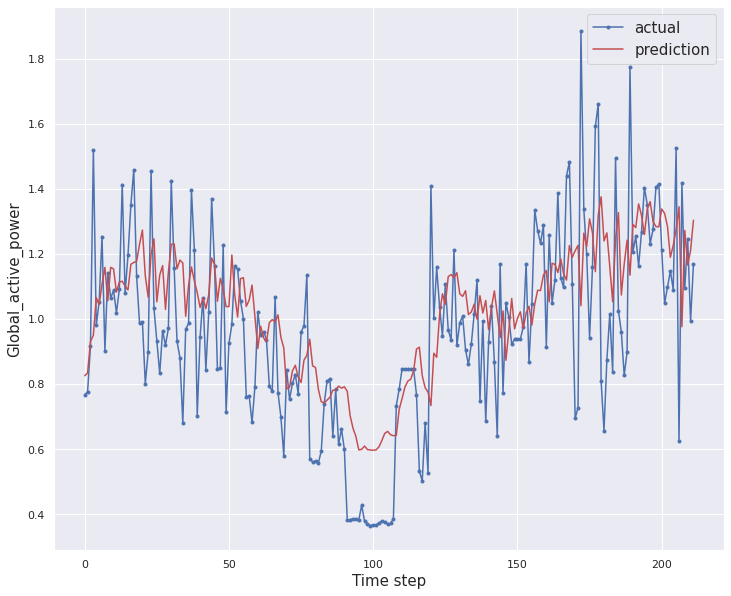

In [ ]:
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


## Iteration-5

* Added L2 Regularizer to Conv-1a
* Added L2 Regularizer to Conv-1b
* Added L2 Regularizer to Conv-1c


In [ ]:
inputs = Input(shape=(28,1), name='series')
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.01))(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.05))(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same', kernel_regularizer=keras.regularizers.l2(l2=0.1))(inputs)
conv1 = concatenate([conv1_a, conv1_b, conv1_c])
conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

#conv1 = BatchNormalization()(conv1)
msblock = relu(conv1)
out = GlobalAveragePooling1D()(conv1)

# Flatten the ouput
#out = Flatten()(out)
out = Dense(units=64)(out)
out = Dense(units=192)(out)
out = relu(out)

attblock = Multiply()([out, msblock, conv2])
attblock = Flatten()(attblock)
attblock = Dense(units=1)(attblock)

model = Model(inputs, attblock, name='MACNN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
model.summary()
 



Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,batch_size=10, shuffle=False)

Epoch 1/100
120/120 [==============================] - 2s 6ms/step - loss: 0.5457 - val_loss: 0.2418
Epoch 2/100
120/120 [==============================] - 0s 3ms/step - loss: 0.2400 - val_loss: 0.1514
Epoch 3/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1716 - val_loss: 0.1079
Epoch 4/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1394 - val_loss: 0.0891
Epoch 5/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1235 - val_loss: 0.0808
Epoch 6/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1158 - val_loss: 0.0774
Epoch 7/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1111 - val_loss: 0.0753
Epoch 8/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1077 - val_loss: 0.0729
Epoch 9/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1047 - val_loss: 0.0737
Epoch 10/100
120/120 [==============================] - 0s 3ms/step - loss: 0.1025 - val_lo

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




(1200,)
Train rmse: 0.08311797040913277
Validation rmse: 0.2204197030884183
MAPE: 18.402


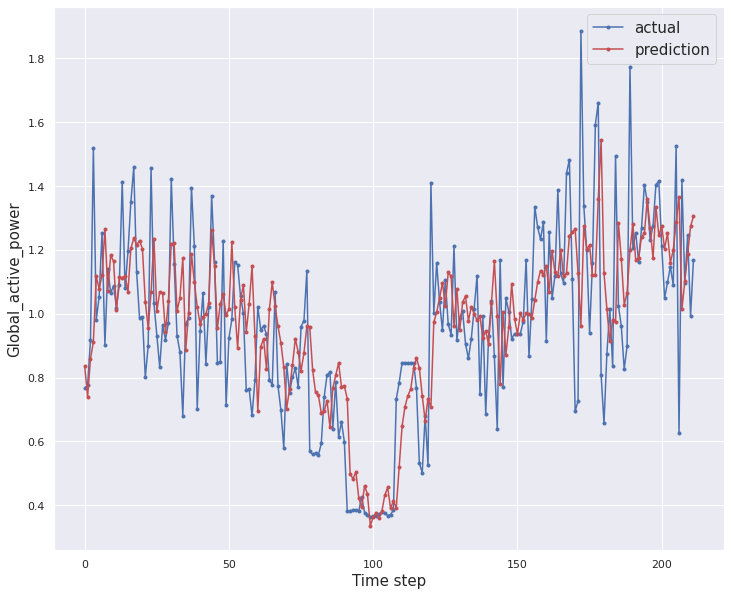

In [ ]:
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction", marker='.')
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


# **Hyperparameter Optimization**

* We will try to fine tune the basic architectures with the help of hyperparameter optimization
* Package used - Keras Tuner
* It helps to select the best hyperparameters for the tensorflow model
* We need to define a hyperparameter space for this

# Household Power Consumption Data

# Hyperparameter Optimization-II

## LSTM

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 1, 7) (1246, 1) (182, 1, 7) (182, 1)


In [ ]:
def build_model_lstm(hp, window = 1):
  model = Sequential()
  model.add(LSTM(units=hp.Choice("input_layer", values = [16,32,64,100, 128,256],default = 100),
                       input_shape=(train_X.shape[1], train_X.shape[2]))),
  for i in range(0,1):
    model.add(Dropout(hp.Choice('dropout_'+str(i), values =[0.0, 0.1, 0.2], default = 0.1)))
  #model.add(Dropout(0.2))
  #model.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mse', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model

In [ ]:
def build_model_lstm_2(hp, window = 1):
  model = Sequential()
  model.add(LSTM(units=hp.Choice("input_layer", values = [16,32,64],default = 32),
                       input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)),
  for i in range(0,1):
    model.add(LSTM(units=hp.Choice("input_layer"+str(i+1), values = [8,16], default=16)))
  model.add(Dropout(hp.Choice('dropout_'+str(i), values =[0.0, 0.1, 0.2], default = 0.1)))
  #model.add(Dropout(0.2))
  #model.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model

### Random Search

* loss Function optimized - **MSE**

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_lstm,
                     objective = 'val_loss',
                     metrics = [keras.metrics.MeanAbsolutePercentageError(name = 'mape')],
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'power_consumption_lstm'
                     )


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.0, 0.1, 0.2], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in random_search/power_consumption_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.009717964961086884
Score: 0.019562264904379845
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.2
learning_rate: 0.0009047565178049741
Score: 0.019776854664087296
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.2
learning_rate: 0.00498177102602746
Score: 0.019891569390892982
Trial summary
Hyperparameters:
input_layer: 32
dropout_0: 0.1
learning_rate: 0.0006868185034064186
Score: 0.019903501495718956
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.1
learning_rate: 0.0015302538523483166
Score: 0.019916163757443428
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.0
learning_rate: 0.0003716883458691013
Score: 0.019916259683668613
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.1
learning_rate: 0.0071379271271374166
Score: 0

[0.019524235278367996, 46.07636642456055]

* loss Function optimized - **MAE**

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_lstm,
                     objective = 'val_loss',
                     loss = 'mae',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'power_consumption_lstm_mae'
                     )


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.0, 0.1, 0.2], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 30 Complete [00h 00m 22s]
val_loss: 0.10350383818149567

Best val_loss So Far: 0.10117129608988762
Total elapsed time: 00h 12m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in random_search/power_consumption_lstm_mae
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.1
learning_rate: 0.0071379271271374166
Score: 0.10117129608988762
Trial summary
Hyperparameters:
input_layer: 100
dropout_0: 0.2
learning_rate: 0.00427775755932623
Score: 0.10129531100392342
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.0
learning_rate: 0.003028225115404566
Score: 0.10135713592171669
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.009717964961086884
Score: 0.10136159136891365
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.1
learning_rate: 0.001906169987120838
Score: 0.10145717486739159
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.2
learning_rate: 0.0019173279125498611
Score: 0.10154794156551361
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.2
learning_rate: 0.00498177102602746
Score: 0.10

0.10114622861146927

* trying the impact of a extra layer

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_lstm_2,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'power_consumption_lstm'
                     )


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
input_layer1 (Choice)
{'default': 16, 'conditions': [], 'values': [8, 16], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.0, 0.1, 0.2], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 20 Complete [00h 00m 49s]
val_loss: 0.11242390796542168

Best val_loss So Far: 0.1000545360147953
Total elapsed time: 00h 13m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in random_search/power_consumption_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 64
input_layer1: 16
dropout_0: 0.2
learning_rate: 0.009717964961086884
Score: 0.1000545360147953
Trial summary
Hyperparameters:
input_layer: 16
input_layer1: 16
dropout_0: 0.0
learning_rate: 0.0030034861977052255
Score: 0.10075314342975616
Trial summary
Hyperparameters:
input_layer: 16
input_layer1: 16
dropout_0: 0.2
learning_rate: 0.0019173279125498611
Score: 0.1008676290512085
Trial summary
Hyperparameters:
input_layer: 32
input_layer1: 16
dropout_0: 0.2
learning_rate: 0.00427775755932623
Score: 0.10143355280160904
Trial summary
Hyperparameters:
input_layer: 32
input_layer1: 16
dropout_0: 0.0
learning_rate: 0.0012872133964141523
Score: 0.10193975642323494
Trial summary
Hyperparameters:
input_layer: 64
input_layer1: 8
dropout_0: 0.1
learning_rate: 0.001021366446510005
Score: 0.1027977280318737
Trial summary
Hyper

0.09966107457876205

* Run iterations with loss function as MAE

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_lstm,
                     objective = 'val_loss',
                     loss = 'mae',
                     metrics = [keras.metrics.MeanAbsolutePercentageError(name = 'mape')],
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'power_consumption_lstm'
                     )


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.0, 0.1, 0.2], 'ordered': True}
loss_fn (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mae', 'mse', 'mape'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 20 Complete [00h 01m 07s]
val_loss: 0.10445554926991463

Best val_loss So Far: 0.10090966150164604
Total elapsed time: 00h 10m 13s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in random_search/power_consumption_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 64
dropout_0: 0.1
loss_fn: mape
learning_rate: 0.00427775755932623
Score: 0.10090966150164604
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.2
loss_fn: mape
learning_rate: 0.009717964961086884
Score: 0.10137531533837318
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.1
loss_fn: mae
learning_rate: 0.0030034861977052255
Score: 0.10149603709578514
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.2
loss_fn: mape
learning_rate: 0.0019173279125498611
Score: 0.10200120136141777
Trial summary
Hyperparameters:
input_layer: 64
dropout_0: 0.1
loss_fn: mae
learning_rate: 0.0012872133964141523
Score: 0.10202014446258545
Trial summary
Hyperparameters:
input_layer: 32
dropout_0: 0.0
loss_fn: mse
learning_rate: 0.0015302538523483166
Score: 0.10210367292165756
Trial summary
Hyperparameters:
inp

[0.10074682533740997, 47.325748443603516]

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

### Hyoerband Optimization

In [ ]:
hyp_tuner = Hyperband(
    build_model_lstm,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    metrics = [keras.metrics.MeanAbsolutePercentageError(name='mape')],
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='power_consumption_lstm'
)

In [ ]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2], 'ordered': True}
loss_fn (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mae', 'mse', 'mape'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
hyp_tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 90 Complete [00h 00m 20s]
val_loss: 0.01997898332774639

Best val_loss So Far: 0.019832612946629524
Total elapsed time: 00h 15m 18s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in hyperband/power_consumption_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.1
loss_fn: mse
learning_rate: 0.001021366446510005
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 86031c0aec6a6469980888842238434e
Score: 0.019832612946629524
Trial summary
Hyperparameters:
input_layer: 64
dropout_0: 0.1
loss_fn: mse
learning_rate: 0.004989949018079344
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 4d9227bae25215855848f6e2261d3982
Score: 0.01995858922600746
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.2
loss_fn: mse
learning_rate: 0.0009901005254978382
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.01997898332774639
Trial summary
Hyperparameters:
input_layer: 128
dropout_0: 0.1
loss_fn: mse
learning_rate: 0.001021366446510005
tuner/epochs: 50
tuner/initi

[0.019744746387004852, 46.25662612915039]

### * Bayesian Optimization

In [ ]:
bay_tuner = BayesianOptimization(
    build_model_lstm,
    objective='val_loss',
    max_trials = 20,
    loss = 'mae',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='power_consumption_lstm_mae'
)

In [ ]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 3
input_layer (Choice)
{'default': 100, 'conditions': [], 'values': [16, 32, 64, 100, 128, 256], 'ordered': True}
dropout_0 (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.0, 0.1, 0.2], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
bay_tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 20 Complete [00h 01m 56s]
val_loss: 0.10072876140475273

Best val_loss So Far: 0.10072876140475273
Total elapsed time: 00h 21m 48s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in bayesian/power_consumption_lstm_mae
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.01
Score: 0.10072876140475273
Trial summary
Hyperparameters:
input_layer: 16
dropout_0: 0.1
learning_rate: 0.01
Score: 0.10087646916508675
Trial summary
Hyperparameters:
input_layer: 64
dropout_0: 0.1
learning_rate: 0.01
Score: 0.10091137513518333
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.01
Score: 0.10101298242807388
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.01
Score: 0.1010606586933136
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.01
Score: 0.10109014809131622
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.2
learning_rate: 0.01
Score: 0.10109488666057587
Trial summary
Hyperparameters:
input_layer: 256
dropout_0: 0.1
learning_rate: 0.01
Score: 0.10117444396

0.10068996995687485

In [ ]:
def build_model_lstm_2(hp, window = 1):
  model = Sequential()
  model.add(LSTM(units=hp.Choice("input_layer", values = [16,32,64],default = 32),
                       input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)),
  for i in range(0,1):
    model.add(LSTM(units=hp.Choice("input_layer"+str(i+1), values = [8,16], default=16)))
  model.add(Dropout(hp.Choice('dropout_'+str(i), values =[0.0, 0.1, 0.2], default = 0.1)))
  #model.add(Dropout(0.2))
  #model.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values =[1e-2, 1e-3, 4e-3, 7e-3,9e-3], default = 1e-3)))
  return model

In [ ]:
bay_tuner = BayesianOptimization(
    build_model_lstm_2,
    objective='val_loss',
    max_trials = 15,
    loss = 'mae',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='power_consumption_lstm_mae_extralayer'
)

In [ ]:
bay_tuner.search(train_X, train_y, epochs=MAX_EPOCHS, validation_data=(test_X, test_y))

Trial 15 Complete [00h 00m 49s]
val_loss: 0.10333475470542908

Best val_loss So Far: 0.10054030641913414
Total elapsed time: 00h 11m 00s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(test_X, test_y)

Results summary
Results in bayesian/power_consumption_lstm_mae_extralayer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 16
input_layer1: 16
dropout_0: 0.0
learning_rate: 0.01
Score: 0.10054030641913414
Trial summary
Hyperparameters:
input_layer: 16
input_layer1: 8
dropout_0: 0.2
learning_rate: 0.01
Score: 0.10079668462276459
Trial summary
Hyperparameters:
input_layer: 16
input_layer1: 8
dropout_0: 0.0
learning_rate: 0.01
Score: 0.10087607428431511
Trial summary
Hyperparameters:
input_layer: 64
input_layer1: 8
dropout_0: 0.2
learning_rate: 0.01
Score: 0.10088404640555382
Trial summary
Hyperparameters:
input_layer: 64
input_layer1: 16
dropout_0: 0.0
learning_rate: 0.01
Score: 0.10101764649152756
Trial summary
Hyperparameters:
input_layer: 16
input_layer1: 16
dropout_0: 0.2
learning_rate: 0.01
Score: 0.10108853131532669
Trial summary
Hyperparameters:
input_layer: 32
input_layer1: 16
dropout_0: 0.1
learning_rate: 0.01
Score: 

0.10032577067613602

## CNN

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 7) (1246, 1) (182, 7) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 7, 1)
Validation set shape (182, 7, 1)


In [ ]:
def build_model_cnn(hp, window = 1):
  model_cnn = Sequential()
  model_cnn.add(Conv1D(filters=hp.Int("input_layer",min_value = 32, max_value = 256, step =32),
                       kernel_size=hp.Choice("kernel_size_1",values =[2,3,4], default =2), activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]))),
  model_cnn.add(MaxPooling1D(pool_size=2, padding='same'))
  model_cnn.add(Flatten())
  model_cnn.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 50,  64]), activation='relu'))
  model_cnn.add(Dense(window))
  model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model_cnn


### Random Search

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_model_cnn,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'power_consumption_cnn'
                     )


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
Dense_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 30 Complete [00h 00m 22s]
val_loss: 0.018994566053152084

Best val_loss So Far: 0.018895771354436874
Total elapsed time: 00h 11m 14s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in random_search/power_consumption_cnn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 32
kernel_size_1: 3
Dense_1: 8
learning_rate: 0.0030034861977052255
Score: 0.018895771354436874
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 3
Dense_1: 50
learning_rate: 0.00786845764554907
Score: 0.018954546190798283
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 4
Dense_1: 64
learning_rate: 0.005846158011503419
Score: 0.018994566053152084
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 3
Dense_1: 64
learning_rate: 0.00427775755932623
Score: 0.01904110051691532
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 2
Dense_1: 50
learning_rate: 0.0023104521755375647
Score: 0.01909396518021822
Trial summary
Hyperparameters:
input_layer: 160
kernel_size_1: 2
Dense_1: 50
learning_rate: 0.001021366446510005
Score: 0.019331197254359722
Trial summary
Hyperparameter

0.018757130950689316

### Hyperband Optmization

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2
hyp_tuner = Hyperband(
    build_model_cnn,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='power_consumption_cnn'
)

In [ ]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
Dense_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
hyp_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 90 Complete [00h 00m 22s]
val_loss: 0.019711879082024097

Best val_loss So Far: 0.01889963075518608
Total elapsed time: 00h 07m 58s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in hyperband/power_consumption_cnn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 3
Dense_1: 64
learning_rate: 0.00427775755932623
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: ce6db720ae95ffceab4cb783b8484896
Score: 0.01889963075518608
Trial summary
Hyperparameters:
input_layer: 32
kernel_size_1: 3
Dense_1: 32
learning_rate: 0.003931395207345373
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: cc46170fe3e885b9a648d7fd59cd54c7
Score: 0.019163386896252632
Trial summary
Hyperparameters:
input_layer: 32
kernel_size_1: 3
Dense_1: 8
learning_rate: 0.0030034861977052255
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 4c08ba53090463ee397c4c50cd506cce
Score: 0.01923835463821888
Trial summary
Hyperparameters:
input_layer: 192
kernel_size_1: 3
Dense_1: 16
learning_rate

0.01884332112967968

### Bayesian Optimization

In [ ]:
bay_tuner = BayesianOptimization(
    build_model_cnn,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='power_consumption_cnn'
)

In [ ]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 4
input_layer (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
Dense_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
bay_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 30 Complete [00h 00m 17s]
val_loss: 0.019245601259171963

Best val_loss So Far: 0.01823839358985424
Total elapsed time: 00h 10m 19s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in bayesian/power_consumption_cnn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 2
Dense_1: 64
learning_rate: 0.01
Score: 0.01823839358985424
Trial summary
Hyperparameters:
input_layer: 160
kernel_size_1: 2
Dense_1: 64
learning_rate: 0.01
Score: 0.018366013653576374
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 2
Dense_1: 64
learning_rate: 0.01
Score: 0.01837369240820408
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 2
Dense_1: 64
learning_rate: 0.01
Score: 0.01843133382499218
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 2
Dense_1: 64
learning_rate: 0.01
Score: 0.018439996987581253
Trial summary
Hyperparameters:
input_layer: 256
kernel_size_1: 2
Dense_1: 64
learning_rate: 0.01
Score: 0.0186960119754076
Trial summary
Hyperparameters:
input_layer: 128
kernel_size_1: 2
Dense_1: 64
learning_rate: 0.01
Score: 0.01870179921388626
Trial 

0.01814936473965645

## CNN-LSTM

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 7) (1246, 1) (182, 7) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 7, 1)
Validation set shape (182, 7, 1)


In [ ]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1246, 1, 7, 1)
Validation set shape (182, 1, 7, 1)


In [ ]:
def build_cnn_lstm(hp, window=1):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(hp.Int("cnn_input", min_value = 32, max_value = 256, step = 32),
                                   kernel_size=hp.Choice("kernel_size_1",values =[2,3,4,7], default =2), padding='same', activation='relu'), input_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(hp.Choice("units", [8,16,32,50,64,100]), activation='relu'))
  model.add(Dense(window))
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model


### Random Search


In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 40
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_cnn_lstm,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'power_consumption_cnn_lstm_mae'
                     )


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64, 100], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(X_train_series_sub, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series_sub, test_y))

Trial 40 Complete [00h 00m 21s]
val_loss: 0.11044272407889366

Best val_loss So Far: 0.09805009141564369
Total elapsed time: 00h 20m 41s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series_sub, test_y)

Results summary
Results in random_search/power_consumption_cnn_lstm_mae
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 4
units: 50
learning_rate: 0.00786845764554907
Score: 0.09805009141564369
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 7
units: 64
learning_rate: 0.00427775755932623
Score: 0.09986777231097221
Trial summary
Hyperparameters:
cnn_input: 32
kernel_size_1: 7
units: 100
learning_rate: 0.003931395207345373
Score: 0.10041963309049606
Trial summary
Hyperparameters:
cnn_input: 160
kernel_size_1: 4
units: 16
learning_rate: 0.005105804073255703
Score: 0.10047557950019836
Trial summary
Hyperparameters:
cnn_input: 160
kernel_size_1: 4
units: 100
learning_rate: 0.009717964961086884
Score: 0.10071121901273727
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 2
units: 50
learning_rate: 0.0023104521755375647
Score: 0.10075439512729645
Trial summary
Hyperparameters:
cnn_input: 128

0.09791646897792816

### Hyperband Optimization

In [ ]:
MAX_EPOCHS = 50
MAX_TRIALS = 30
EXECUTION_PER_TRIAL = 2
hyp_tuner = Hyperband(
    build_cnn_lstm,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='power_consumption_cnn_lstm'
)

In [ ]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64, 100], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
hyp_tuner.search(X_train_series_sub, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series_sub, test_y))

Trial 90 Complete [00h 00m 44s]
val_loss: 0.10174164175987244

Best val_loss So Far: 0.10082066804170609
Total elapsed time: 00h 16m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series_sub, test_y)

Results summary
Results in hyperband/power_consumption_cnn_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
cnn_input: 192
kernel_size_1: 4
units: 16
learning_rate: 0.0025577783041697117
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.10082066804170609
Trial summary
Hyperparameters:
cnn_input: 256
kernel_size_1: 4
units: 64
learning_rate: 0.0010317434915858203
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.10096664726734161
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 4
units: 50
learning_rate: 0.00786845764554907
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: fec706e40dd8cde5b02c7785cacf5396
Score: 0.10109451413154602
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 7
units: 64
learning_rate: 0.00427775755932623
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_i

0.10070367157459259

### Bayesian Optimization

In [ ]:
bay_tuner = BayesianOptimization(
    build_cnn_lstm,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='power_consumption_cnn_lstm'
)

In [ ]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 4
cnn_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size_1 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 50, 64, 100], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
bay_tuner.search(X_train_series_sub, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series_sub, test_y))

Trial 30 Complete [00h 00m 46s]
val_loss: 0.09998516365885735

Best val_loss So Far: 0.0993487760424614
Total elapsed time: 00h 19m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series_sub, test_y)

Results summary
Results in bayesian/power_consumption_cnn_lstm
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
cnn_input: 32
kernel_size_1: 7
units: 32
learning_rate: 0.01
Score: 0.0993487760424614
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 2
units: 32
learning_rate: 0.01
Score: 0.09937022253870964
Trial summary
Hyperparameters:
cnn_input: 32
kernel_size_1: 7
units: 8
learning_rate: 0.01
Score: 0.09942890703678131
Trial summary
Hyperparameters:
cnn_input: 256
kernel_size_1: 7
units: 100
learning_rate: 0.01
Score: 0.09957489371299744
Trial summary
Hyperparameters:
cnn_input: 32
kernel_size_1: 7
units: 100
learning_rate: 0.01
Score: 0.09967092052102089
Trial summary
Hyperparameters:
cnn_input: 128
kernel_size_1: 7
units: 100
learning_rate: 0.01
Score: 0.099680345505476
Trial summary
Hyperparameters:
cnn_input: 192
kernel_size_1: 7
units: 100
learning_rate: 0.01
Score: 0.09998516365885735
Trial summary
Hyperparameters:
cn

0.09881041944026947

## TCN

In [ ]:
prediction_window = 1

In [ ]:
# Scale dataset

scaler, scaled = scale_data(df_resample_day_y, range=(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, n_out=prediction_window)
#print(reframed)
print("Shape of reframed dataset-",reframed.shape)

Shape of scaled dataset- (1440, 1)
Shape of reframed dataset- (1433, 8)


In [ ]:
total_no_of_weeks = reframed.shape[0]//7
test_data_time_period = 26
train_data_time_period = total_no_of_weeks - test_data_time_period
train_data_time_period


178

In [ ]:
values = reframed.values

n_train_time = train_data_time_period * 7
n_test_time = test_data_time_period * 7
print(n_train_time)
print(n_test_time)
#n_train_time = 1800
train = values[:n_train_time, :]
test = values[n_train_time:n_train_time+n_test_time, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-prediction_window], train[:, -prediction_window:]
test_X, test_y = test[:, :-prediction_window], test[:, -prediction_window:]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

1246
182
(1246, 7) (1246, 1) (182, 7) (182, 1)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1246, 7, 1)
Validation set shape (182, 7, 1)


In [153]:
def build_tcn_model(hp, window = 1):
  tcn_layer = TCN(input_shape=(7,1),
                  nb_filters = hp.Int("filter", min_value=32, max_value=128, step=32),
                  kernel_size = hp.Choice("kerne_size", values=[2,3,4,7], default = 2),
                  dilations =(1,2,4),
                  activation ='relu',
                  use_skip_connections = True)
  model = Sequential([tcn_layer, Dense(window)])
  model.compile(loss = 'mae', 
                optimizer=keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value = 1e-5, max_value = 1e-2, sampling = 'LOG', default = 1e-3)))
  return model

### Random Search

In [154]:
MAX_EPOCHS = 50
MAX_TRIALS = 15
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(build_tcn_model,
                     objective = 'val_loss',
                     seed = 6500,
                     max_trials = MAX_TRIALS,
                     executions_per_trial = EXECUTION_PER_TRIAL,
                     overwrite= True, 
                     directory='random_search',
                     project_name = 'power_consumption_tcn_mae'
                     )


In [155]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
kerne_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [156]:
tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 15 Complete [00h 01m 18s]
val_loss: 0.10455864295363426

Best val_loss So Far: 0.10059387609362602
Total elapsed time: 00h 21m 59s
INFO:tensorflow:Oracle triggered exit


In [157]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in random_search/power_consumption_tcn_mae
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 64
kerne_size: 2
learning_rate: 0.00427775755932623
Score: 0.10059387609362602
Trial summary
Hyperparameters:
filter: 96
kerne_size: 2
learning_rate: 0.00498177102602746
Score: 0.10064996033906937
Trial summary
Hyperparameters:
filter: 96
kerne_size: 7
learning_rate: 0.009717964961086884
Score: 0.10086460411548615
Trial summary
Hyperparameters:
filter: 64
kerne_size: 7
learning_rate: 0.00011859558187718863
Score: 0.10168186947703362
Trial summary
Hyperparameters:
filter: 32
kerne_size: 4
learning_rate: 0.0006868185034064186
Score: 0.10364146530628204
Trial summary
Hyperparameters:
filter: 64
kerne_size: 4
learning_rate: 0.0002851509951970098
Score: 0.10392428189516068
Trial summary
Hyperparameters:
filter: 64
kerne_size: 7
learning_rate: 1.137176368923248e-05
Score: 0.10426443442702293
Trial summary
Hyperparameters:

0.09984854608774185

### Hyperband Optimization

In [163]:
MAX_EPOCHS = 30
MAX_TRIALS = 15
EXECUTION_PER_TRIAL = 2
hyp_tuner = Hyperband(
    build_tcn_model,
    max_epochs=MAX_EPOCHS,
    objective='val_loss',
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='hyperband',
    project_name='power_consumption_tcn'
)

In [164]:
hyp_tuner.search_space_summary()

Search space summary
Default search space size: 3
filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
kerne_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [165]:
hyp_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 90 Complete [00h 00m 44s]
val_loss: 0.11092763394117355

Best val_loss So Far: 0.10128828138113022
Total elapsed time: 00h 28m 15s
INFO:tensorflow:Oracle triggered exit


In [166]:
# Show a summary of the search
hyp_tuner.results_summary()

# Retrieve the best model.
best_model = hyp_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in hyperband/power_consumption_tcn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 64
kerne_size: 4
learning_rate: 0.00499335300623905
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.10128828138113022
Trial summary
Hyperparameters:
filter: 96
kerne_size: 7
learning_rate: 0.009717964961086884
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 3bf97112dfb1f576a4415503cad59c3f
Score: 0.10182320699095726
Trial summary
Hyperparameters:
filter: 96
kerne_size: 7
learning_rate: 0.005846158011503419
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: c5ef4892392ed42423d18f2ceb921f6c
Score: 0.1024157777428627
Trial summary
Hyperparameters:
filter: 32
kerne_size: 7
learning_rate: 0.0071379271271374166
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 6f3ea9ab49d2020329d6f

0.10093279182910919

### Bayesian Optimization

In [158]:
bay_tuner = BayesianOptimization(
    build_tcn_model,
    objective='val_loss',
    max_trials = MAX_TRIALS,
    seed=6500,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='bayesian',
    project_name='power_consumption_tcn'
)

In [159]:
bay_tuner.search_space_summary()

Search space summary
Default search space size: 3
filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
kerne_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 7], 'ordered': True}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [160]:
bay_tuner.search(X_train_series, train_y, epochs=MAX_EPOCHS, validation_data=(X_valid_series, test_y))

Trial 15 Complete [00h 01m 25s]
val_loss: 0.10141503065824509

Best val_loss So Far: 0.09761562198400497
Total elapsed time: 00h 33m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
bay_tuner.results_summary()

# Retrieve the best model.
best_model = bay_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
best_model.evaluate(X_valid_series, test_y)

Results summary
Results in bayesian/power_consumption_tcn
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 32
loss_fn: mse
learning_rate: 0.01
Score: 0.019627375528216362
Trial summary
Hyperparameters:
filter: 256
loss_fn: mse
learning_rate: 0.00025635201566222976
Score: 0.0197864742949605
Trial summary
Hyperparameters:
filter: 160
loss_fn: mse
learning_rate: 7.937560978403946e-05
Score: 0.020181909203529358
Trial summary
Hyperparameters:
filter: 256
loss_fn: mse
learning_rate: 0.01
Score: 0.020290089771151543
Trial summary
Hyperparameters:
filter: 160
loss_fn: mse
learning_rate: 8.122599508219343e-05
Score: 0.020316927693784237
Trial summary
Hyperparameters:
filter: 160
loss_fn: mse
learning_rate: 8.662422068606861e-05
Score: 0.020317671820521355
Trial summary
Hyperparameters:
filter: 160
loss_fn: mse
learning_rate: 8.306738282454494e-05
Score: 0.02034139074385166
Trial summary
Hyperparameters:
filter: 224
loss_fn: mse
learning_

[0.01919439435005188, 46.36173629760742]